In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import copy
import scipy
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt5


figpath = os.path.join(project_root, 'figures_raw')

In [2]:
trial_data_all, subjects, cue_level_names, image_type_names = analyze_expt5.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propleft_by_condition, rt_by_condition = analyze_expt5.get_perf_by_cond()

acc_by_run, dprime_by_run, rt_by_run = analyze_expt5.get_perf_by_run()

acc_by_supcat, dprime_by_supcat, rt_by_supcat = analyze_expt5.get_perf_by_supercateg()

In [3]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt5.get_categ_info()

super_names_plot = copy.deepcopy(super_names)
ind = np.where(np.isin(super_names, 'musical_instrument'))[0][0]
super_names_plot[ind] = 'instrument'

super_names, super_names_plot

(['insect',
  'mammal',
  'vegetable',
  'fruit',
  'tool',
  'musical_instrument',
  'furniture',
  'vehicle'],
 ['insect',
  'mammal',
  'vegetable',
  'fruit',
  'tool',
  'instrument',
  'furniture',
  'vehicle'])

#### Compare trials where target/distractor were natural/artificial

In [4]:
is_natural = np.array([1,1,1,1,0,0,0,0]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)

art_super = np.array(super_names)[~is_natural]
nat_super = np.array(super_names)[is_natural]

art_super, nat_super

(array(['tool', 'musical_instrument', 'furniture', 'vehicle'], dtype='<U18'),
 array(['insect', 'mammal', 'vegetable', 'fruit'], dtype='<U18'))

In [5]:
super_dprime_within_across_nat = np.full(fill_value=0.0, shape=(n_subjects, 2, n_image_types))

for si, ss in enumerate(subjects):

    trial_data = trial_data_all[trial_data_all['subject']==ss]

    nat = is_natural[np.array(trial_data['categ_ind']).astype(int)]
    
    for ii, imtype in enumerate(image_type_names):

        # want superordinate task only, this image type
        inds = (trial_data['cue_level']=='super') & \
                (trial_data['image_type']==imtype)

        # grouping by target/distractor combinations
        inds1 = inds & (np.isin(trial_data['super_name'], nat_super)) & \
                        (np.isin(trial_data['distractor_name'], nat_super))

        inds2 = inds & (np.isin(trial_data['super_name'], art_super)) & \
                        (np.isin(trial_data['distractor_name'],art_super))

        inds3 = inds & (np.isin(trial_data['super_name'], nat_super)) & \
                        (np.isin(trial_data['distractor_name'], art_super))

        inds4 = inds & (np.isin(trial_data['super_name'], art_super)) & \
                        (np.isin(trial_data['distractor_name'], nat_super))

        # print(np.sum(inds1), np.sum(inds2), np.sum(inds3), np.sum(inds4))

        # get all trials where target/distractor were either same/different
        # in terms of natural/artificial status
        same = inds1 | inds2
        diff = inds3 | inds4

        for xx, inds_use in enumerate([same, diff]):
            
            predlabs = np.array(trial_data['resp'])[inds_use]
            reallabs = np.array(trial_data['correct_resp'])[inds_use]
    
            did_respond = predlabs>-1
    
            predlabs = predlabs[did_respond]
            reallabs = reallabs[did_respond]
            
            super_dprime_within_across_nat[si, xx, ii] = stats_utils.get_dprime(predlabs, reallabs)
    

#### d-prime values: two-way repeated measures anova, all subjects

In [6]:
vals = super_dprime_within_across_nat

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['same_diff','image_type'])

print(aov_table)

# then pairwise t-tests (same vs diff)
result = scipy.stats.ttest_rel(vals[:,1,:], vals[:,0,:], axis=0, alternative='two-sided')
tvals = result.statistic
pvals = result.pvalue

df = pd.DataFrame(index=image_type_names)
df['t (same - diff)'] = tvals.round(4)
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df


All subjects:
(30, 2, 5)
                         F Value  Num DF  Den DF        Pr > F
same_diff              73.839098     1.0    29.0  1.828358e-09
image_type            177.032141     4.0   116.0  2.075050e-48
same_diff:image_type    0.949233     4.0   116.0  4.382989e-01


,t (same - diff),p
pool1,3.5176,0.001820
pool2,2.8100,0.008782
pool3,5.6796,0.000019
pool4,4.8724,0.000090
orig,4.6733,0.000105


/user_data/mmhender/featsynth/figures_raw/Grayscale_confusions.pdf


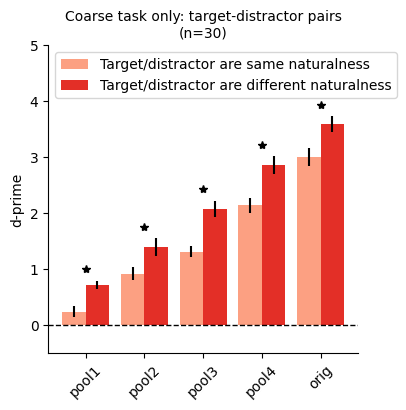

In [7]:
within_across_colors = cm.Reds(np.linspace(0,1,4))[[1,2],:]

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plot_utils.set_all_font_sizes(10)
# plt.figure(figsize=(6,4))
plt.figure(figsize=(4,4))

vals = super_dprime_within_across_nat
within_across_names = ['Target/distractor are same naturalness','Target/distractor are different naturalness']

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lh = []

for ii in range(n_image_types):
    
    for xx, name in enumerate(within_across_names):
    
        h = plt.bar(ii+xjitters[xx], \
                         meanvals[xx,ii], \
                        color = within_across_colors[xx,:], width=barwidth, zorder=0)
        
        plt.errorbar(ii+xjitters[xx], \
                         meanvals[xx,ii], \
                         semvals[xx,ii], \
                        color = 'k',
                        linestyle='none', \
                     # capsize=3, 
                     zorder=10)

        # plt.plot((ii+xjitters[cc]) * np.ones([n_subs_plot,]), \
        #          vals[:,cc,ii], '.', color=[0.8,0.8,0.8], zorder=5)
    
        lh.append(h)

    # for ss in range(n_subs_plot):
            
    #     plt.plot(ii+xjitters, vals[ss,:,ii], '-', color=[0.8,0.8,0.8], zorder=5)
        

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k', zorder=20)

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

ax.legend(lh, within_across_names, loc='upper left')

plt.ylabel('d-prime')

plt.ylim([-.5, 5.0])
# assert(np.all(vals<5.0))
# assert(np.all(vals>-0.5))

plt.title('Coarse task only: target-distractor pairs\n(n=%d)'%(n_subs_plot));

savename = os.path.join(figpath, 'Grayscale_confusions.pdf')
print(savename)
plt.savefig(savename, transparent=True)

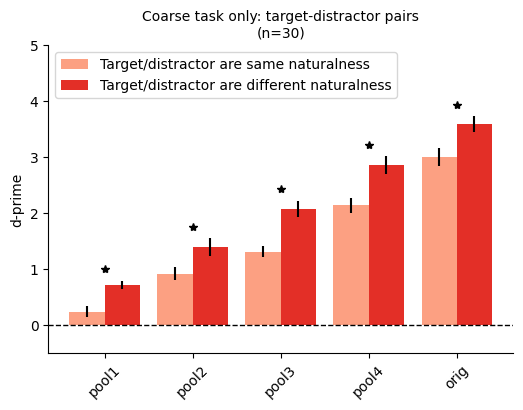

In [9]:
within_across_colors = cm.Reds(np.linspace(0,1,4))[[1,2],:]

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = super_dprime_within_across_nat
within_across_names = ['Target/distractor are same naturalness','Target/distractor are different naturalness']

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lh = []

for ii in range(n_image_types):
    
    for xx, name in enumerate(within_across_names):
    
        h = plt.bar(ii+xjitters[xx], \
                         meanvals[xx,ii], \
                        color = within_across_colors[xx,:], width=barwidth, zorder=0)
        
        plt.errorbar(ii+xjitters[xx], \
                         meanvals[xx,ii], \
                         semvals[xx,ii], \
                        color = 'k',
                        linestyle='none', \
                     # capsize=3, 
                     zorder=10)

        # plt.plot((ii+xjitters[cc]) * np.ones([n_subs_plot,]), \
        #          vals[:,cc,ii], '.', color=[0.8,0.8,0.8], zorder=5)
    
        lh.append(h)

    # for ss in range(n_subs_plot):
            
    #     plt.plot(ii+xjitters, vals[ss,:,ii], '-', color=[0.8,0.8,0.8], zorder=5)
        

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k', zorder=20)

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

ax.legend(lh, within_across_names, loc='upper left')

plt.ylabel('d-prime')

plt.ylim([-.5, 5.0])
# assert(np.all(vals<5.0))
# assert(np.all(vals>-0.5))

plt.title('Coarse task only: target-distractor pairs\n(n=%d)'%(n_subs_plot));

# savename = os.path.join(fig_path, 'Color_dprime.pdf')
# print(savename)
# plt.savefig(savename)

In [8]:
# these will be combined across all subjects (bc we don't have enough trials)
super_dprime_categ_pairs = np.full(fill_value=0.0, shape=(n_image_types, n_super, n_super))

for ii in range(n_image_types):
    
    for s1 in range(n_super):

        # nan for same category pairs
        super_dprime_categ_pairs[ii,s1,s1] = np.nan
        
        for s2 in range(s1+1, n_super):
            
            inds_use = np.array((trial_data_all['cue_level']=='super') & \
                           (trial_data_all['image_type']==image_type_names[ii]) & \
                           (trial_data_all['super_name']==super_names[s1]) & \
                           (trial_data_all['distractor_name']==super_names[s2]))

            predlabs = np.array(trial_data_all['resp'])[inds_use]
            reallabs = np.array(trial_data_all['correct_resp'])[inds_use]
    
            did_respond = predlabs>-1
    
            predlabs = predlabs[did_respond]
            reallabs = reallabs[did_respond]

            d = stats_utils.get_dprime(predlabs, reallabs)

            # this is diagonally symmetric
            super_dprime_categ_pairs[ii, s1, s2] = d
            super_dprime_categ_pairs[ii, s2, s1] = d
    

/user_data/mmhender/featsynth/figures_raw/Grayscale_confusion_matrix_pool1.pdf


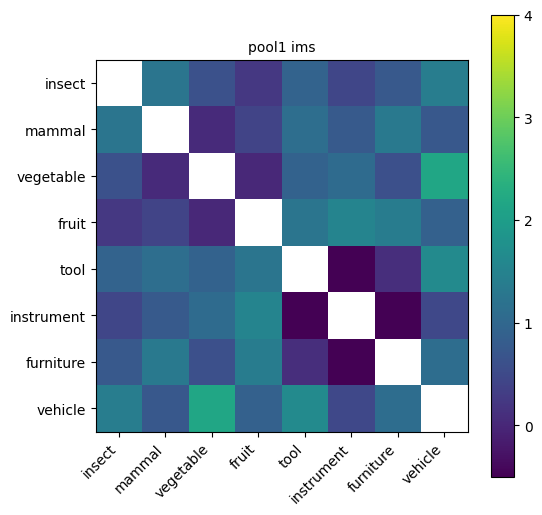

In [9]:

ii = 0;

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(6,6))

# pi=0;

# for ii in range(n_image_types):

vals = super_dprime_categ_pairs[ii,:]

    # pi+=1
    # plt.subplot(2,3,pi)

plt.pcolormesh(vals, vmin=-0.5, vmax=4.0)
plt.axis('square')
plt.title('%s ims'%image_type_names[ii])
# if pi>3:
plt.xticks(np.arange(n_super)+0.5, super_names_plot, rotation=45, ha = 'right')
    # plt.xlabel('distractor categ')
# else:
#     plt.xticks(np.arange(n_super)+0.5, [], rotation=45, ha = 'right')
# if np.mod(pi, 3)==1:
plt.yticks(np.arange(n_super)+0.5, super_names_plot)
#     # plt.ylabel('actual categ')
# else:
#     plt.yticks(np.arange(n_super)+0.5, [])

plt.gca().invert_yaxis()
# pi=6
# plt.subplot(2,3,pi)
# plt.pcolormesh(np.array([[-0.5, 4.5]]), vmin=-0.5, vmax=4.5)
plt.colorbar(ticks = np.arange(0, 4.1, 1))




savename = os.path.join(figpath, 'Grayscale_confusion_matrix_%s.pdf'%(image_type_names[ii]))
print(savename)
plt.savefig(savename, transparent=True)

# plt.suptitle('Superordinate task only: d-prime for different pairs of categories')

Text(0.5, 0.98, 'Superordinate task only: d-prime for different pairs of categories')

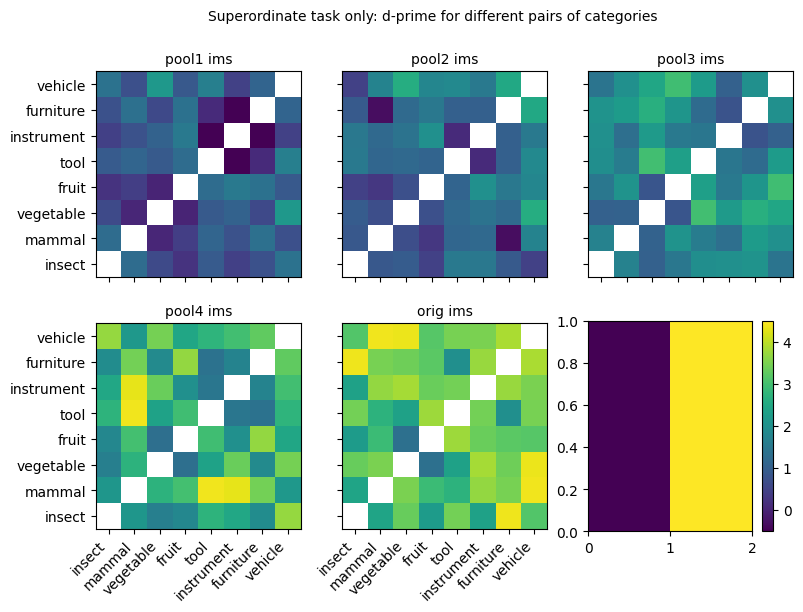

In [11]:

plt.figure(figsize=(9,6))

pi=0;

for ii in range(n_image_types):

    vals = super_dprime_categ_pairs[ii,:]

    pi+=1
    plt.subplot(2,3,pi)
    
    plt.pcolormesh(vals, vmin=-0.5, vmax=4.5)
    plt.axis('square')
    plt.title('%s ims'%image_type_names[ii])
    if pi>3:
        plt.xticks(np.arange(n_super)+0.5, super_names_plot, rotation=45, ha = 'right')
        # plt.xlabel('distractor categ')
    else:
        plt.xticks(np.arange(n_super)+0.5, [], rotation=45, ha = 'right')
    if np.mod(pi, 3)==1:
        plt.yticks(np.arange(n_super)+0.5, super_names_plot)
        # plt.ylabel('actual categ')
    else:
        plt.yticks(np.arange(n_super)+0.5, [])

pi=6
plt.subplot(2,3,pi)
plt.pcolormesh(np.array([[-0.5, 4.5]]), vmin=-0.5, vmax=4.5)
plt.colorbar()

plt.suptitle('Superordinate task only: d-prime for different pairs of categories')